In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
 
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tqdm.auto import tqdm

In [2]:
path = "./facades/train/"


class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.filenames = glob(str(Path(path) / "*"))
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        real = image[:, :, : image_width // 2]
        condition = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)

        return real, condition

In [3]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.model = nn.Sequential(
        #Вниз
        nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),         
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),         
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),    
        #вверх
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.Dropout(0.5),    
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.Dropout(0.5), 
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh()        
        
        )
        
    def forward(self, x):
        return self.model(x)

In [4]:
gen = Generator(3, 3)
print(gen)

Generator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): ConvTranspose2d(512

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.model = nn.Sequential(
        #Вниз
        nn.Conv2d(2*input_channels, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),         
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 1, kernel_size=1))
    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        return self.model(x)     

In [6]:
disc = Discriminator(3)
print(disc)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [7]:
adversarial_loss_f  = nn.BCEWithLogitsLoss()

reconstruction_loss_f = nn.L1Loss()

In [8]:
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

def display_progress(cond, fake, real, figsize=(10,5)):
    cond = cond.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[2].imshow(fake)
    ax[1].imshow(real)
    plt.show()

In [9]:
LAMBDA = 200
def gen_step(real_images, conditioned_images):
    fake_images = gen(conditioned_images).to(DEVICE)
    disc_logits = disc(fake_images, conditioned_images).to(DEVICE)
    adversarial_loss = adversarial_loss_f(disc_logits, torch.ones_like(disc_logits))

    # calculate reconstruction loss
    recon_loss = reconstruction_loss_f(fake_images, real_images)
     

    return adversarial_loss + LAMBDA * recon_loss

def disc_step(real_images, conditioned_images):
    conditioned_images.to(DEVICE) 
    real_images.to(DEVICE) 
    fake_images = gen(conditioned_images).detach().to(DEVICE)
    fake_logits = disc(fake_images, conditioned_images).to(DEVICE)

    real_logits = disc(real_images, conditioned_images).to(DEVICE)

    fake_loss = adversarial_loss_f(fake_logits, torch.zeros_like(fake_logits))
    real_loss = adversarial_loss_f(real_logits, torch.ones_like(real_logits))
    return (real_loss + fake_loss) / 2


In [10]:
LR = 0.0002

gen_opt = torch.optim.Adam(gen.parameters(), lr=LR)
disc_opt = torch.optim.Adam(disc.parameters(), lr=LR)

0it [00:00, ?it/s]

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.8307, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(81.3038, device='cuda:0', grad_fn=<AddBackward0>)


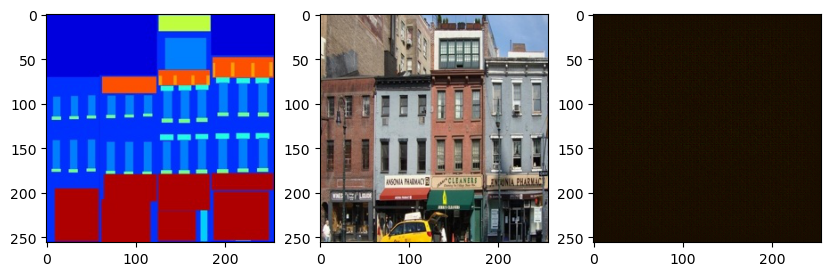

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7571, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(62.2113, device='cuda:0', grad_fn=<AddBackward0>)


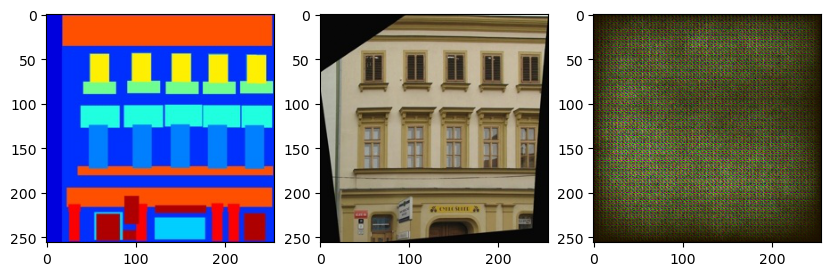

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7043, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(45.6586, device='cuda:0', grad_fn=<AddBackward0>)


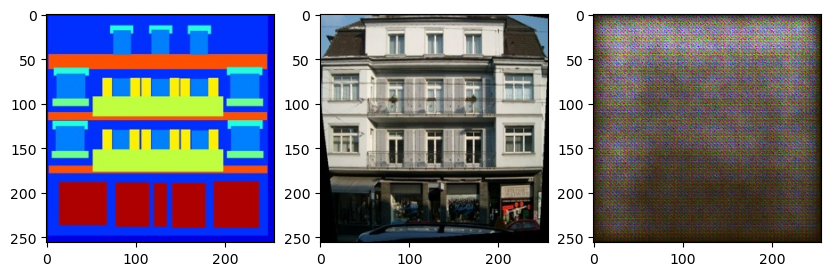

0it [00:00, ?it/s]

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7021, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(41.8251, device='cuda:0', grad_fn=<AddBackward0>)


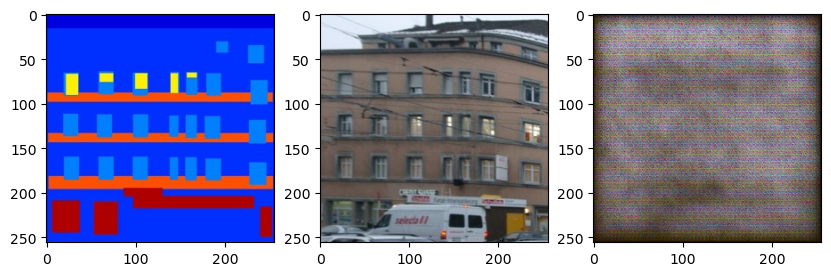

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6957, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(39.7393, device='cuda:0', grad_fn=<AddBackward0>)


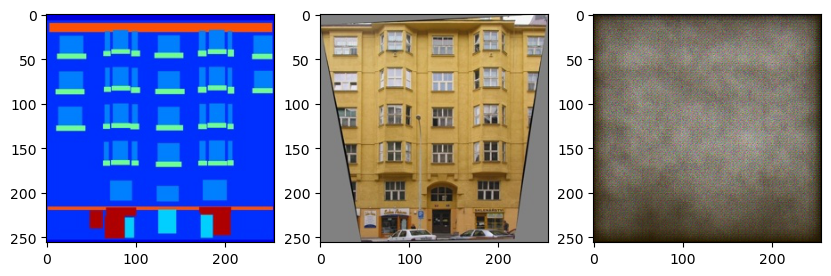

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6947, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(39.2584, device='cuda:0', grad_fn=<AddBackward0>)


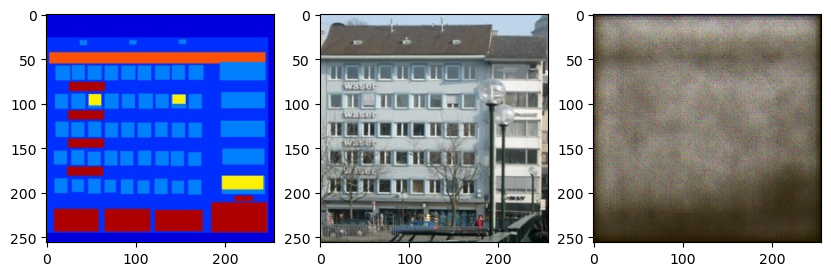

0it [00:00, ?it/s]

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6942, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(38.5981, device='cuda:0', grad_fn=<AddBackward0>)


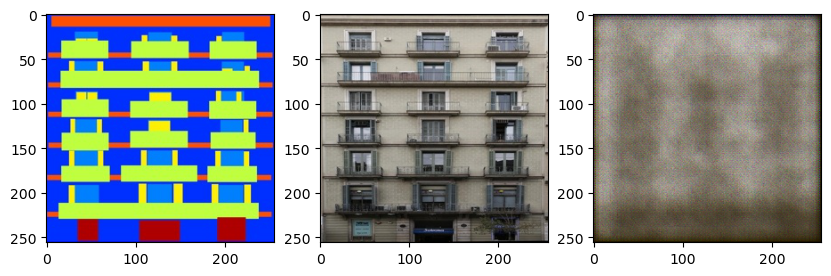

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6938, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(35.8241, device='cuda:0', grad_fn=<AddBackward0>)


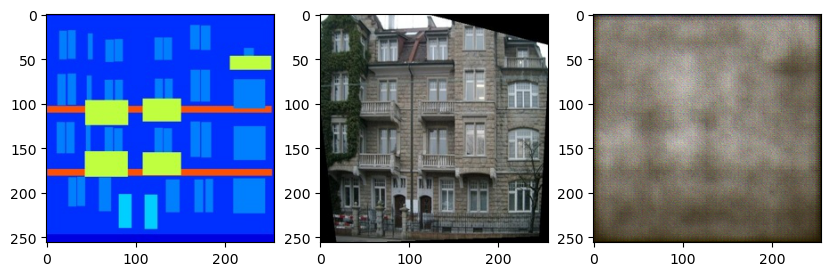

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6938, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(38.8379, device='cuda:0', grad_fn=<AddBackward0>)


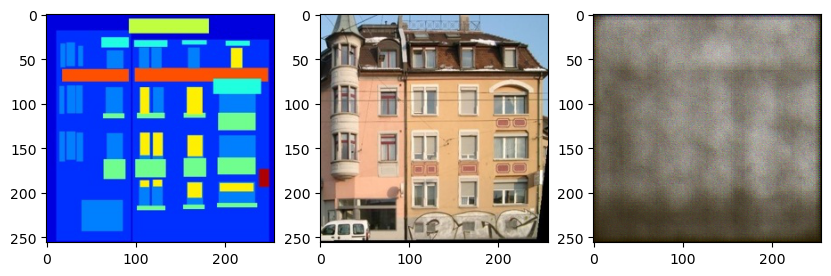

0it [00:00, ?it/s]

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6937, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(35.5280, device='cuda:0', grad_fn=<AddBackward0>)


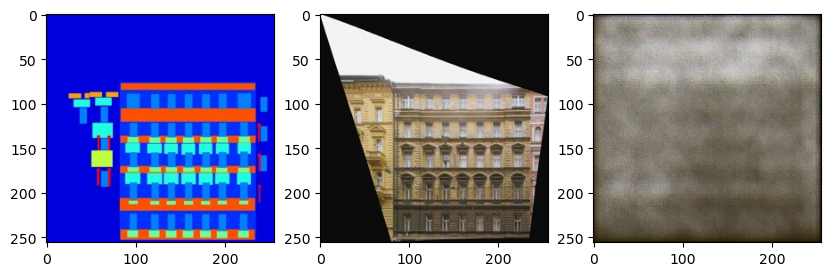

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6937, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(35.3512, device='cuda:0', grad_fn=<AddBackward0>)


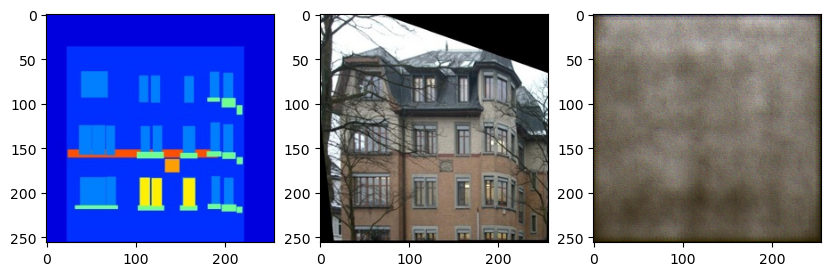

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(37.5740, device='cuda:0', grad_fn=<AddBackward0>)


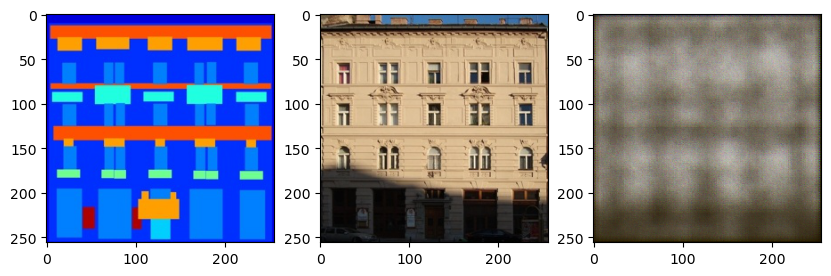

0it [00:00, ?it/s]

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(35.4400, device='cuda:0', grad_fn=<AddBackward0>)


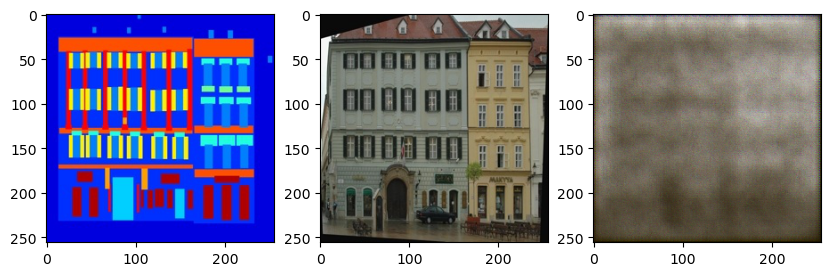

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(35.2461, device='cuda:0', grad_fn=<AddBackward0>)


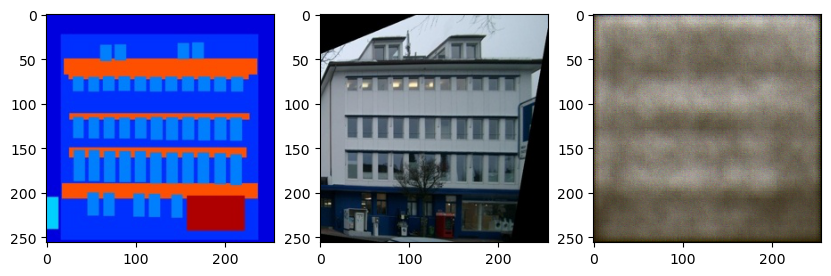

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6934, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(34.5634, device='cuda:0', grad_fn=<AddBackward0>)


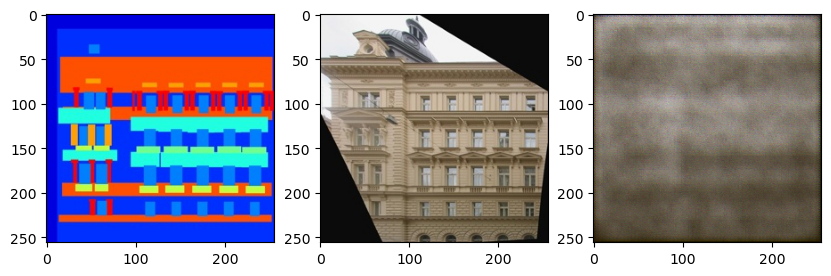

0it [00:00, ?it/s]

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(33.0851, device='cuda:0', grad_fn=<AddBackward0>)


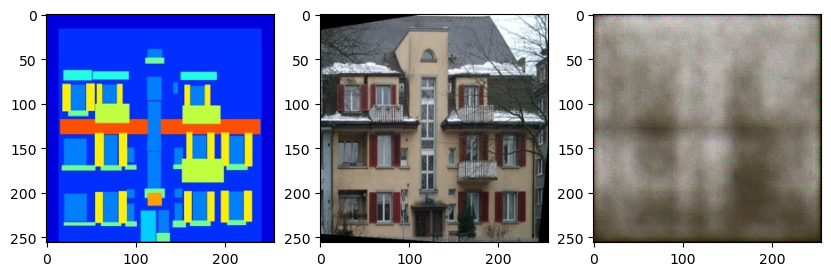

Discriminator Loss tensor(0.6934, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(36.1151, device='cuda:0', grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


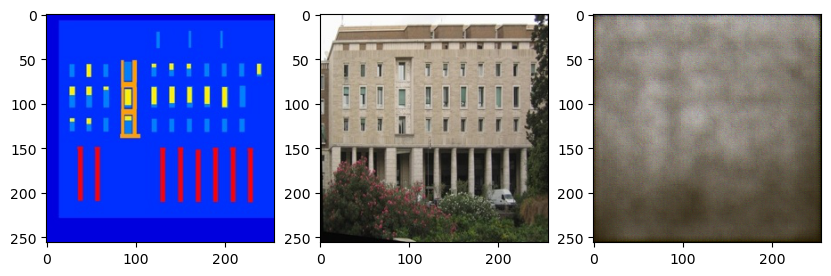

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(35.2243, device='cuda:0', grad_fn=<AddBackward0>)


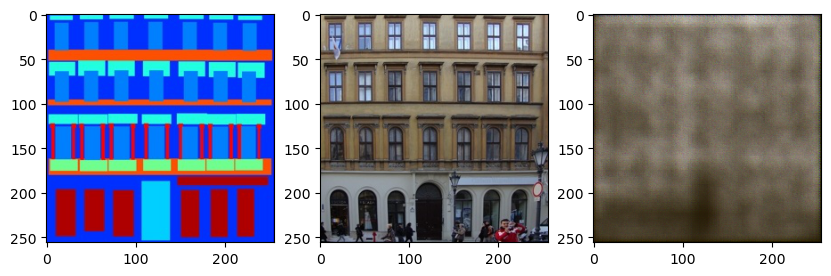

0it [00:00, ?it/s]

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6934, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(32.3528, device='cuda:0', grad_fn=<AddBackward0>)


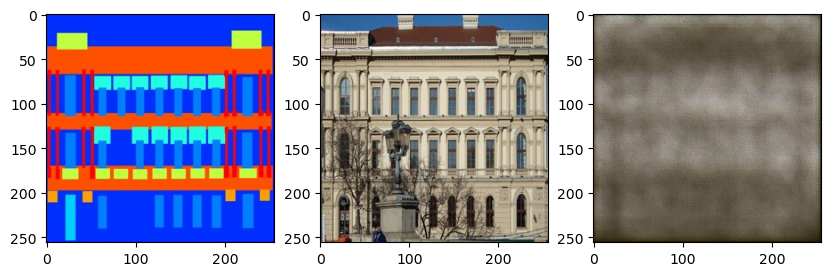

Discriminator Loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6934, device='cuda:0', grad_fn=<DivBackward0>)
Generator Loss tensor(34.3390, device='cuda:0', grad_fn=<AddBackward0>)


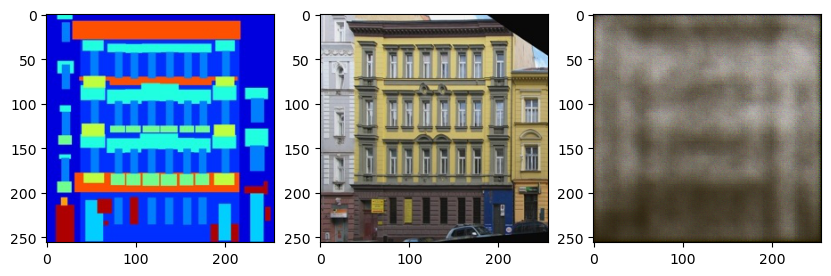

In [ ]:
DEVICE = "cuda"
dataset = FacadesDataset(path, target_size=256)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
gen.to(DEVICE)
disc.to(DEVICE)
adversarial_loss_f.to(DEVICE)
reconstruction_loss_f.to(DEVICE)

for epoch in range(10):
    for batch_idx, batch in tqdm(enumerate(dataloader)):
        real, condition = batch
        real = real.cuda()
        condition = condition.cuda()
        d_loss = None
        disc_opt.zero_grad()
        d_loss = disc_step(real, condition)
        
        d_loss.backward()

        disc_opt.step()
   
        g_loss = None
        gen_opt.zero_grad()
        g_loss = gen_step(real, condition)
        
        g_loss.backward()

        gen_opt.step()
        if  batch_idx%10 == 1:
            print('Discriminator Loss', d_loss)
            print('Generator Loss', g_loss)
            fake = gen(condition).detach()
            display_progress(condition[0], fake[0], real[0])
         